In [1]:
import torch
import os
from torchnet import meter
from collections import Counter

from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
from transformers import T5Tokenizer, EncoderDecoderModel
from torch.utils.data.sampler import SubsetRandomSampler

from src.dataset import KEMDyDataset
from src.selection_methods import query_samples
from src.util import out_put
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from src.kobert_tokenizer import KoBertTokenizer

from module.KoBertEmotionRecognition import KoBERTEmotionRecognition
from module.Wav2VecEmotionRecognition import Wav2VecEmotionRecognition
from module.LateFusion import LatefusionModule

from transformers import AutoConfig


import wandb


tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')



The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


In [2]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

@torch.no_grad()
def val(k, modal, method):
    
    l_type='emotion'
    use_gpu = True
    if use_gpu:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    file_name=f'./results/{modal}/{modal}_{method}real_{l_type}_k{k}_2/{modal}_{l_type}_k{k}_2'

    val_data = KEMDyDataset(modal=modal, k=k, kind='val', l_type=l_type)

    if modal == 'text':
        model = KoBERTEmotionRecognition().to(device)
        model.load_state_dict(torch.load(file_name+'_encbest.pth'))

    if modal == 'wav':
        model_name_or_path = "kresnik/wav2vec2-large-xlsr-korean"
        config = AutoConfig.from_pretrained(model_name_or_path,
                                            num_labels=7,
                                            label2id = {'neutral': 0, 'happy': 1, 'surprise': 2, 'angry': 3, 'sad': 4, 'disqust': 5, 'fear': 6},
                                            id2label = {0: 'neutral', 1: 'happy', 2: 'surprise', 3: 'angry', 4: 'sad', 5: 'disqust', 6: 'fear'}
                                            )
        
        model = Wav2VecEmotionRecognition.from_pretrained(model_name_or_path, config=config).to(device)
        model.load_state_dict(torch.load(file_name + '_encbest.pth'))


    if modal == 'both':

        model_name_or_path = "kresnik/wav2vec2-large-xlsr-korean"
        config = AutoConfig.from_pretrained(model_name_or_path,
                                            num_labels=7,
                                            label2id = {'neutral': 0, 'happy': 1, 'surprise': 2, 'angry': 3, 'sad': 4, 'disqust': 5, 'fear': 6},
                                            id2label = {0: 'neutral', 1: 'happy', 2: 'surprise', 3: 'angry', 4: 'sad', 5: 'disqust', 6: 'fear'}
                                            )

        model = LatefusionModule(model_name_or_path, config).to(device)
        model.load_state_dict(torch.load(file_name + '_encbest.pth'))


    val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

    model.eval()

    pred_label = []
    true_label = []

    for ii, (inputs, target) in enumerate(val_loader):
        data, mask = inputs[0].to(device), inputs[1].to(device)
        target = target.to(device)
        
        if modal == 'both':
            w_data, w_mask = inputs[2].to(device), inputs[3].to(device)

        if modal == 'text' or modal == 'wav':
            output, encode_out = model(data, mask, output_attentions=True, output_hidden_states=True)
        
        if modal == 'both':
            output, _, _, encode_out = model(data, mask, w_data, w_mask)

        _, pred = output.data.topk(1, dim=1)
        pred = pred.t().squeeze()

        pred_label.append(pred.detach().cpu())
        true_label.append(target.detach().cpu())

    pred_label = torch.cat(pred_label, 0)
    true_label = torch.cat(true_label, 0)

    return pred_label, true_label

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2619, 512]) torch.Size([2619, 512]) torch.Size([2619])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2935, 512]) torch.Size([2935, 512]) torch.Size([2935])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2288, 512]) torch.Size([2288, 512]) torch.Size([2288])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2716, 512]) torch.Size([2716, 512]) torch.Size([2716])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2904, 512]) torch.Size([2904, 512]) torch.Size([2904])
[[10542   427    42    29    44     6    30]
 [  685   825     8     3     3     1     3]
 [  156    28    33     1     1     1     1]
 [  188    15     1    20     3     1     0]
 [  139     6     1     0    46     0     1]
 [   90     9     1     3     1     3     1]
 [   46     1     3     0     0     0    14]]


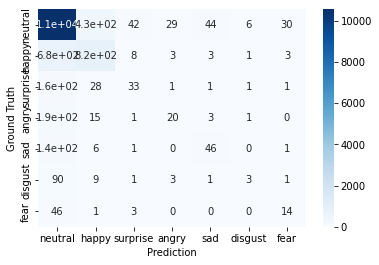

val f1 : 0.8362878315451888, val micro f1 : 0.8529936116476008, val macro f1 : 0.35210812396966046, val accuracy : 0.8529936116476007, val precision : 0.8287296019745068 val recall : 0.8529936116476007


In [6]:
pred_labels = []
true_labels = []

modal = 'text'
method = 'Coreset'
for i in range(1,6):
    pred_label, true_label = val(i, modal=modal, method=method)
    pred_labels.append(pred_label)
    true_labels.append(true_label)

pred_labels = torch.cat(pred_labels, 0)
true_labels = torch.cat(true_labels, 0)

val_f1 = f1_score(true_labels, pred_labels, average='weighted')
val_macro_f1 = f1_score(true_labels, pred_labels, average='macro')
val_micro_f1 = f1_score(true_labels, pred_labels, average='micro')
val_accuracy = accuracy_score(true_labels, pred_labels)
val_precision = precision_score(true_labels, pred_labels, average='weighted')
val_recall = recall_score(true_labels, pred_labels, average='weighted')


cf_matrix = confusion_matrix(true_labels, pred_labels)
print(cf_matrix)
sns.heatmap((cf_matrix.T / np.sum(a.T, axis=0)).T, annot=True,
        fmt=".2f%", cmap='Blues')

plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['neutral', 'happy', 'surprise', 'angry', 'sad', 'disgust', 'fear'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['neutral', 'happy', 'surprise', 'angry', 'sad', 'disgust', 'fear'])

plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

# plt.savefig('./figure/confusion_matrix.png')
plt.show()
print('val f1 : {}, val micro f1 : {}, val macro f1 : {}, val accuracy : {}, val precision : {} val recall : {}'.format(val_f1, val_micro_f1, val_macro_f1, val_accuracy, val_precision, val_recall))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2619, 512]) torch.Size([2619, 512]) torch.Size([2619])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2935, 512]) torch.Size([2935, 512]) torch.Size([2935])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2288, 512]) torch.Size([2288, 512]) torch.Size([2288])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2716, 512]) torch.Size([2716, 512]) torch.Size([2716])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2904, 512]) torch.Size([2904, 512]) torch.Size([2904])
[[10482   467    50    46    43    24     8]
 [  664   828    12    14     4     4     2]
 [  168    32    18     0     1     1     1]
 [  195    17     1     8     1     6     0]
 [  150    10     1     6    25     1     0]
 [   89    13     1     2     0     2     1]
 [   40     5     1     3     2     0    13]]


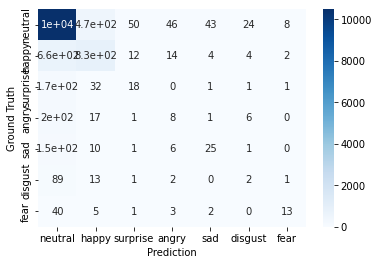

val f1 : 0.8278399529338436, val micro f1 : 0.845045312732135, val macro f1 : 0.3088184353291741, val accuracy : 0.8450453127321349, val precision : 0.8158557955395586 val recall : 0.8450453127321349


In [7]:
pred_labels = []
true_labels = []

modal = 'text'
method = 'Random'
for i in range(1,6):
    pred_label, true_label = val(i, modal=modal, method=method)
    pred_labels.append(pred_label)
    true_labels.append(true_label)

pred_labels = torch.cat(pred_labels, 0)
true_labels = torch.cat(true_labels, 0)

val_f1 = f1_score(true_labels, pred_labels, average='weighted')
val_macro_f1 = f1_score(true_labels, pred_labels, average='macro')
val_micro_f1 = f1_score(true_labels, pred_labels, average='micro')
val_accuracy = accuracy_score(true_labels, pred_labels)
val_precision = precision_score(true_labels, pred_labels, average='weighted')
val_recall = recall_score(true_labels, pred_labels, average='weighted')


cf_matrix = confusion_matrix(true_labels, pred_labels)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True,
        cmap='Blues')

plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['neutral', 'happy', 'surprise', 'angry', 'sad', 'disgust', 'fear'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['neutral', 'happy', 'surprise', 'angry', 'sad', 'disgust', 'fear'])

plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

# plt.savefig('./figure/confusion_matrix.png')
plt.show()
print('val f1 : {}, val micro f1 : {}, val macro f1 : {}, val accuracy : {}, val precision : {} val recall : {}'.format(val_f1, val_micro_f1, val_macro_f1, val_accuracy, val_precision, val_recall))

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2619, 512]) torch.Size([2619, 512]) torch.Size([2619])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2935, 512]) torch.Size([2935, 512]) torch.Size([2935])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2288, 512]) torch.Size([2288, 512]) torch.Size([2288])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2716, 512]) torch.Size([2716, 512]) torch.Size([2716])


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


torch.Size([2904, 512]) torch.Size([2904, 512]) torch.Size([2904])
[[10542   427    42    29    44     6    30]
 [  685   825     8     3     3     1     3]
 [  156    28    33     1     1     1     1]
 [  188    15     1    20     3     1     0]
 [  139     6     1     0    46     0     1]
 [   90     9     1     3     1     3     1]
 [   46     1     3     0     0     0    14]]


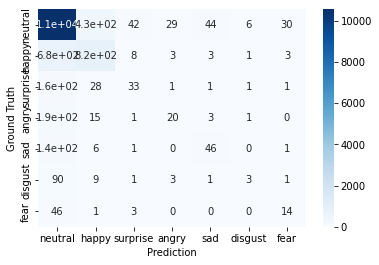

val f1 : 0.8362878315451888, val micro f1 : 0.8529936116476008, val macro f1 : 0.35210812396966046, val accuracy : 0.8529936116476007, val precision : 0.8287296019745068 val recall : 0.8529936116476007


In [8]:
pred_labels = []
true_labels = []

modal = 'text'
method = 'Coreset'
for i in range(1,6):
    pred_label, true_label = val(i, modal=modal, method=method)
    pred_labels.append(pred_label)
    true_labels.append(true_label)

pred_labels = torch.cat(pred_labels, 0)
true_labels = torch.cat(true_labels, 0)

val_f1 = f1_score(true_labels, pred_labels, average='weighted')
val_macro_f1 = f1_score(true_labels, pred_labels, average='macro')
val_micro_f1 = f1_score(true_labels, pred_labels, average='micro')
val_accuracy = accuracy_score(true_labels, pred_labels)
val_precision = precision_score(true_labels, pred_labels, average='weighted')
val_recall = recall_score(true_labels, pred_labels, average='weighted')


cf_matrix = confusion_matrix(true_labels, pred_labels)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True,
        cmap='Blues')

plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['neutral', 'happy', 'surprise', 'angry', 'sad', 'disgust', 'fear'])
plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], ['neutral', 'happy', 'surprise', 'angry', 'sad', 'disgust', 'fear'])

plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

# plt.savefig('./figure/confusion_matrix.png')
plt.show()
print('val f1 : {}, val micro f1 : {}, val macro f1 : {}, val accuracy : {}, val precision : {} val recall : {}'.format(val_f1, val_micro_f1, val_macro_f1, val_accuracy, val_precision, val_recall))